Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

---

### Network Architecture

References
    
- [1] Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "[Imagenet classification with deep convolutional neural networks.](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)" In Advances in Neural Information Processing Systems, pp. 1097-1105. 2012.


## Imports

In [20]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms
from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image


#if torch.cuda.is_available():
#    torch.backends.cudnn.deterministic = True

In [21]:
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [22]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)

In [3]:
def set_deterministic():
    if  torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)

In [44]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 60

# Architecture
NUM_CLASSES = 10

# Other
dtype = torch.float
device = torch.device("mps")
set_all_seeds(RANDOM_SEED)

# Deterministic behavior not yet supported by AdaptiveAvgPool2d
#set_deterministic()

In [45]:
import sys

sys.path.insert(0, "..") # to include ../helper_evaluate.py etc.

from helper_evaluate import compute_accuracy
from helper_data import get_dataloaders_cifar10
from helper_train import train_classifier_simple_v1

In [46]:
### Set random seed ###
set_all_seeds(RANDOM_SEED)

##########################
### Dataset
##########################

train_transforms = transforms.Compose([transforms.Resize((40, 40)),
                                       transforms.RandomCrop((33, 33)),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((40, 40)),
                                      transforms.CenterCrop((33, 33)),
                                      transforms.ToTensor()])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    validation_fraction=0.1)

Files already downloaded and verified


In [47]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 3, 33, 33])
Image label dimensions: torch.Size([256])
tensor([0, 2, 3, 5, 4, 8, 9, 6, 9, 7])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 33, 33])
Image label dimensions: torch.Size([256])
tensor([6, 9, 3, 5, 7, 3, 4, 1, 8, 0])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 33, 33])
Image label dimensions: torch.Size([256])
tensor([2, 6, 3, 1, 1, 1, 1, 2, 4, 8])


## Model

In [48]:
##########################
### MODEL
##########################

NUM_CLASSES = 10


class AlexNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),        
            #FALCON
            # INPUT CONV  33, 33, 3, 64, 3, 2, 1, ...
            nn.ReLU(inplace=True),
            #FALCON CIFAR ALEXNET line 1207 
            #INPUT RELU = 64*17*17
            nn.MaxPool2d(kernel_size=2),
            #FALCON Input MAXPOOL 17*17*64, 2, 2, ...
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            
            
            
            nn.ReLU(inplace=True),
            
            
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x
    
    

    def output(self, x):
        out = self.features(x)
        #out = self.avgpool(out)
        out = out.view(out.size(0), 256 * 1 * 1)
        out = self.classifier(out)
        return out
    
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
summary(model, (3, 33, 33))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 17, 17]           1,792
              ReLU-2           [-1, 64, 17, 17]               0
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4            [-1, 192, 8, 8]         110,784
              ReLU-5            [-1, 192, 8, 8]               0
         MaxPool2d-6            [-1, 192, 4, 4]               0
            Conv2d-7            [-1, 384, 4, 4]         663,936
              ReLU-8            [-1, 384, 4, 4]               0
            Conv2d-9            [-1, 256, 4, 4]         884,992
             ReLU-10            [-1, 256, 4, 4]               0
           Conv2d-11            [-1, 256, 4, 4]         590,080
             ReLU-12            [-1, 256, 4, 4]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
           Linear-14                 [-

In [49]:

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [50]:
log_dict = train_classifier_simple_v1(num_epochs=NUM_EPOCHS, model=model, 
                                      optimizer=optimizer, device=device, 
                                      train_loader=train_loader, valid_loader=valid_loader, 
                                      logging_interval=25)

Epoch: 001/060 | Batch 0000/0175 | Loss: 2.3028
Epoch: 001/060 | Batch 0025/0175 | Loss: 2.1418
Epoch: 001/060 | Batch 0050/0175 | Loss: 2.1729
Epoch: 001/060 | Batch 0075/0175 | Loss: 1.9979
Epoch: 001/060 | Batch 0100/0175 | Loss: 1.9824
Epoch: 001/060 | Batch 0125/0175 | Loss: 1.9953
Epoch: 001/060 | Batch 0150/0175 | Loss: 1.9111
***Epoch: 001/060 | Train. Acc.: 28.413% | Loss: 1.854
***Epoch: 001/060 | Valid. Acc.: 29.140% | Loss: 1.823
Time elapsed: 0.45 min
Epoch: 002/060 | Batch 0000/0175 | Loss: 1.9166
Epoch: 002/060 | Batch 0025/0175 | Loss: 1.7830
Epoch: 002/060 | Batch 0050/0175 | Loss: 1.8447
Epoch: 002/060 | Batch 0075/0175 | Loss: 1.8316
Epoch: 002/060 | Batch 0100/0175 | Loss: 1.6422
Epoch: 002/060 | Batch 0125/0175 | Loss: 1.6397
Epoch: 002/060 | Batch 0150/0175 | Loss: 1.7031
***Epoch: 002/060 | Train. Acc.: 38.625% | Loss: 1.633
***Epoch: 002/060 | Valid. Acc.: 40.440% | Loss: 1.597
Time elapsed: 0.89 min
Epoch: 003/060 | Batch 0000/0175 | Loss: 1.6069
Epoch: 003/060

Epoch: 018/060 | Batch 0125/0175 | Loss: 0.9999
Epoch: 018/060 | Batch 0150/0175 | Loss: 0.9422
***Epoch: 018/060 | Train. Acc.: 66.299% | Loss: 0.950
***Epoch: 018/060 | Valid. Acc.: 66.560% | Loss: 0.949
Time elapsed: 7.99 min
Epoch: 019/060 | Batch 0000/0175 | Loss: 0.9369
Epoch: 019/060 | Batch 0025/0175 | Loss: 1.0000
Epoch: 019/060 | Batch 0050/0175 | Loss: 0.9054
Epoch: 019/060 | Batch 0075/0175 | Loss: 0.8415
Epoch: 019/060 | Batch 0100/0175 | Loss: 0.9218
Epoch: 019/060 | Batch 0125/0175 | Loss: 0.8928
Epoch: 019/060 | Batch 0150/0175 | Loss: 1.0573
***Epoch: 019/060 | Train. Acc.: 65.938% | Loss: 0.956
***Epoch: 019/060 | Valid. Acc.: 65.500% | Loss: 0.968
Time elapsed: 8.45 min
Epoch: 020/060 | Batch 0000/0175 | Loss: 0.9159
Epoch: 020/060 | Batch 0025/0175 | Loss: 0.9696
Epoch: 020/060 | Batch 0050/0175 | Loss: 0.8456
Epoch: 020/060 | Batch 0075/0175 | Loss: 0.9398
Epoch: 020/060 | Batch 0100/0175 | Loss: 0.8057
Epoch: 020/060 | Batch 0125/0175 | Loss: 0.8548
Epoch: 020/060

Epoch: 036/060 | Batch 0000/0175 | Loss: 0.5769
Epoch: 036/060 | Batch 0025/0175 | Loss: 0.5020
Epoch: 036/060 | Batch 0050/0175 | Loss: 0.5239
Epoch: 036/060 | Batch 0075/0175 | Loss: 0.6194
Epoch: 036/060 | Batch 0100/0175 | Loss: 0.6082
Epoch: 036/060 | Batch 0125/0175 | Loss: 0.5115
Epoch: 036/060 | Batch 0150/0175 | Loss: 0.6042
***Epoch: 036/060 | Train. Acc.: 80.033% | Loss: 0.565
***Epoch: 036/060 | Valid. Acc.: 72.760% | Loss: 0.806
Time elapsed: 15.93 min
Epoch: 037/060 | Batch 0000/0175 | Loss: 0.5833
Epoch: 037/060 | Batch 0025/0175 | Loss: 0.6069
Epoch: 037/060 | Batch 0050/0175 | Loss: 0.6282
Epoch: 037/060 | Batch 0075/0175 | Loss: 0.5970
Epoch: 037/060 | Batch 0100/0175 | Loss: 0.5604
Epoch: 037/060 | Batch 0125/0175 | Loss: 0.6232
Epoch: 037/060 | Batch 0150/0175 | Loss: 0.5324
***Epoch: 037/060 | Train. Acc.: 80.165% | Loss: 0.565
***Epoch: 037/060 | Valid. Acc.: 71.900% | Loss: 0.816
Time elapsed: 16.37 min
Epoch: 038/060 | Batch 0000/0175 | Loss: 0.5134
Epoch: 038/0

Epoch: 053/060 | Batch 0125/0175 | Loss: 0.3551
Epoch: 053/060 | Batch 0150/0175 | Loss: 0.2920
***Epoch: 053/060 | Train. Acc.: 89.821% | Loss: 0.291
***Epoch: 053/060 | Valid. Acc.: 75.000% | Loss: 0.833
Time elapsed: 23.33 min
Epoch: 054/060 | Batch 0000/0175 | Loss: 0.2953
Epoch: 054/060 | Batch 0025/0175 | Loss: 0.2638
Epoch: 054/060 | Batch 0050/0175 | Loss: 0.2610
Epoch: 054/060 | Batch 0075/0175 | Loss: 0.2453
Epoch: 054/060 | Batch 0100/0175 | Loss: 0.3839
Epoch: 054/060 | Batch 0125/0175 | Loss: 0.2464
Epoch: 054/060 | Batch 0150/0175 | Loss: 0.2525
***Epoch: 054/060 | Train. Acc.: 90.719% | Loss: 0.270
***Epoch: 054/060 | Valid. Acc.: 75.440% | Loss: 0.843
Time elapsed: 23.77 min
Epoch: 055/060 | Batch 0000/0175 | Loss: 0.2581
Epoch: 055/060 | Batch 0025/0175 | Loss: 0.3232
Epoch: 055/060 | Batch 0050/0175 | Loss: 0.3117
Epoch: 055/060 | Batch 0075/0175 | Loss: 0.3616
Epoch: 055/060 | Batch 0100/0175 | Loss: 0.3648
Epoch: 055/060 | Batch 0125/0175 | Loss: 0.4055
Epoch: 055/0

## Evaluation

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline


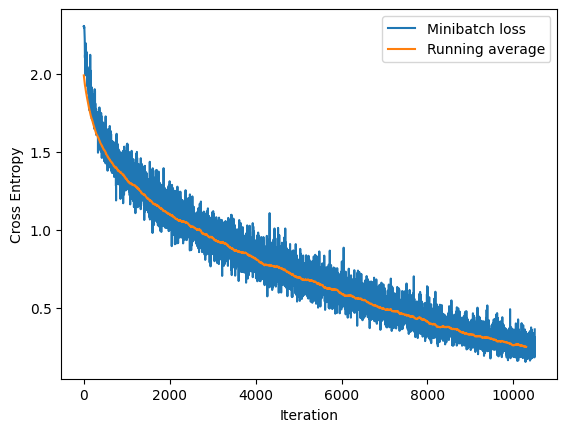

In [52]:
loss_list = log_dict['train_loss_per_batch']

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

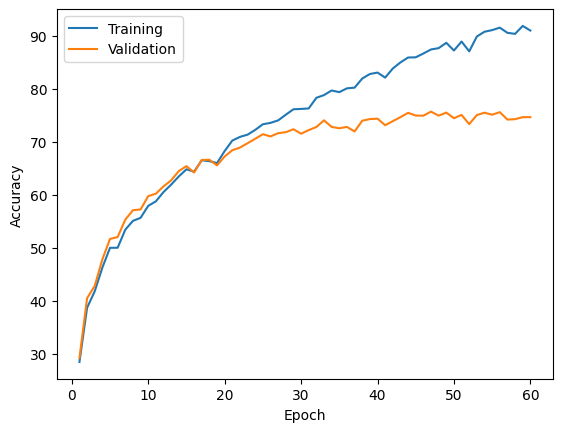

In [51]:
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['valid_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [43]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=test_loader,
                                 device=device)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=device)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=device)
    

print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 74.32%
Validation ACC: 74.32%
Test ACC: 73.13%


In [ ]:
# # Write results to a file so that we can test the C++ accuracy thing
# with open("./preds_AlexNet.txt", "w") as p:
#     with open("./ground_AlexNet.txt", "w") as h:
#         first = True
#         for images, labels in test_loader:
#             # Run the network inference to get the predicted values
#             pred = sum(model(images.cuda()).cpu().tolist(), [])

#             # Generate the ground truths
#             ground = sum([ [ 1 if i == l else 0 for i in range(10) ] for l in labels ], [])

#             # Append to the files
#             if first:
#                 first = False
#             else:
#                 p.write(" ")
#                 h.write(" ")
#             p.write(' '.join([ str(s) for s in pred]))
#             h.write(' '.join([ str(s) for s in ground]))

In [ ]:
# Extract the weights and junk
params = [(name, p.data.cpu().numpy()) for (name, p) in model.named_parameters()]

In [ ]:
# Find a single input batch
for images, _ in train_loader:
    break

# Assert the target directory exists
path = "./preload/CIFAR/AlexNet/"
if not os.path.exists(path):
    os.makedirs(path)

# Write the used inputs and outputs
np.savetxt(fname=f"{path}/input_0", delimiter=" ", X=images.cuda().view(-1, 3 * 33 * 33).tolist())
np.savetxt(fname=f"{path}/outputlayer8_0", delimiter=" ", X=model.output(images.cuda().view(-1, 3, 33, 33)).data.cpu().view(-1))

# Write the layers we want
for (i, resize_to) in enumerate([ (11*11*3, 96), (5*5*96, 256), (3*3*256, 384), (3*3*384, 384), (3*3*384, 256), None, None, None ]):
    # Write the layer's weights
    if resize_to is not None:
        np.savetxt(fname=f"{path}/weight{i + 1}_0", delimiter=" ", X=params[2 * i][1].reshape(resize_to).tolist())
    else:
        np.savetxt(fname=f"{path}/weight{i + 1}_0", delimiter=" ", X=params[2 * i][1].tolist())

    # Write the biases
    np.savetxt(fname=f"{path}/bias{i + 1}_0", delimiter=" ", X=params[2 * i + 1][1].tolist())


In [ ]:
%watermark -iv